# Neural Network for RUL Prediction

## Introduction

This notebook focuses on designing and implementing neural network models for predicting the Remaining Useful Life (RUL) of engines using the NASA CMAPSS dataset. The dataset provides multivariate time-series data capturing engine operational and sensor measurements. By analyzing these sequences, we aim to estimate the RUL, which is critical for predictive maintenance and avoiding unexpected failures.

### Objectives
1. **Develop a Baseline Model:**
   - Implement a baseline neural network using **Long Short-Term Memory (LSTM)** layers to leverage the sequential nature of the data.
   - Evaluate the baseline model's performance as a benchmark.

2. **Experiment with a Transformer-Based Model:**
   - Implement a more advanced architecture based on transformers for sequence modeling and feature extraction.
   - Compare its performance with the LSTM-based baseline model.

### Plan
1. **Prepare the Data:**
   - Use the preprocessed and scaled dataset created in previous notebooks.
   - Ensure the dataset supports both original features and optional engineered features for flexibility in experimentation.

2. **Baseline Model (LSTM):**
   - Use LSTM layers to capture temporal dependencies in the sequence data.
   - Evaluate the model's performance using Mean Squared Error (MSE) as the loss metric.

3. **Transformer-Based Model:**
   - Design a transformer architecture for sequence-to-sequence modeling.
   - Focus on capturing long-range dependencies and complex interactions among features.

4. **Model Comparison and Evaluation:**
   - Compare the models on key metrics such as Mean Absolute Error (MAE) and MSE.
   - Analyze the advantages and trade-offs of each approach.

### Why Use LSTMs and Transformers?
- **LSTMs:** 
  - Effective at capturing temporal dependencies and patterns in sequential data.
  - Provide a strong benchmark for sequence modeling tasks.
- **Transformers:**
  - Offer enhanced capability to model long-range dependencies compared to LSTMs.
  - Utilize attention mechanisms to focus on the most relevant parts of the sequence.

### Expected Outcome
By the end of this notebook, we aim to:
- Establish a strong baseline model for RUL prediction.
- Explore the potential of transformer-based models for handling sequence data.
- Gain insights into the strengths and limitations of these architectures for predictive maintenance tasks.

Let's begin by loading the prepared dataset and setting up the baseline model.


# Baseline Model: RNN-Based Approach

## Introduction
The first model we will explore for predicting Remaining Useful Life (RUL) is a baseline approach based on a **Recurrent Neural Network (RNN)**. RNNs are well-suited for sequence-based data as they are designed to handle temporal dependencies by processing sequences one step at a time, maintaining a hidden state that captures information about previous steps.

## Objective
The objective of this baseline model is to:
- Establish a foundation for sequence modeling using a simple RNN architecture.
- Capture the temporal dependencies in the NASA Turbofan Degradation dataset to predict RUL.
- Provide a baseline performance metric to compare with more advanced models like GRUs and transformers.

## Why RNNs?
Recurrent Neural Networks (RNNs) are among the simplest neural network architectures for sequence data. They work well for datasets where:
- Sequential order and temporal relationships are important.
- Shorter sequences or relatively simple temporal dynamics are present.

While RNNs have limitations in capturing long-term dependencies due to vanishing gradient problems, they offer a straightforward starting point for understanding sequence-based modeling.

## Model Architecture Outline
1. **Input Layer:**
   - Takes the sequence of sensor readings and operational settings for a fixed window of cycles as input.
   - Each sequence represents a series of measurements for a single engine.

2. **RNN Layers:**
   - A stack of RNN layers processes the sequence data, maintaining a hidden state to encode temporal dependencies.

3. **Fully Connected Layers:**
   - Outputs from the final RNN layer are passed through fully connected layers for further processing.

4. **Output Layer:**
   - A single neuron outputs the predicted RUL for the input sequence.

## Expected Outcomes
- Provide baseline results for RUL prediction using a simple RNN model.
- Understand the limitations of standard RNNs, such as difficulties in capturing long-term dependencies.
- Use this model as a benchmark to evaluate the improvements offered by more advanced architectures like GRUs and transformers.

In the next section, we will define and implement this RNN-based baseline model.


# Preparing our existing CMAPSSDataset for a sequence based network
For that see the code in v3/dataset.py.

In [2]:
from torch.utils.data import DataLoader
from codebase.v3.dataset import CMAPSSDataset, SequenceCMAPSSDataset

# Define a function to prepare the DataLoader
def prepare_dataloader(data_dir, data_index, feature_cols, batch_size=32, mode="train", compute_engineered_features=True, sequence_length=30):
    """
    Prepares the DataLoader for the CMAPSS dataset.
    
    Args:
        data_dir (str): Directory containing the dataset files.
        data_index (int): Index of the dataset file to load (0 to 3).
        feature_cols (list): List of feature columns to use.
        batch_size (int): Batch size for the DataLoader.
        mode (str): Mode of the dataset, "train" or "test".
        compute_engineered_features (bool): Whether to include engineered features.
        
    Returns:
        DataLoader: PyTorch DataLoader for the CMAPSS dataset.
    """
    # Initialize the dataset
    dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode=mode,
        compute_engineered_features=compute_engineered_features
    )
    
    # Wrap it with the sequence-based dataset
    sequence_dataset = SequenceCMAPSSDataset(dataset, sequence_length=sequence_length)

    # Create DataLoader
    dataloader = DataLoader(sequence_dataset, batch_size=batch_size, shuffle=False)
    return dataloader


In [3]:
def test_sequence_dataset(dataloader, mode="train"):
    """
    Test the SequenceCMAPSSDataset and display an example output.

    Args:
        dataset (CMAPSSDataset): The original CMAPSSDataset instance.
        sequence_length (int): Length of each sequence.
        batch_size (int): Batch size for the DataLoader.
    """
    
    # Fetch one batch
    for batch_idx, batch in enumerate(dataloader):
        if mode == "train":
            sequences, targets, engine_ids, _ = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Targets Shape: {targets.shape}")  # Expected: (batch_size,)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Corresponding Target (First in Batch):\n{targets[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        else:
            sequences, engine_ids, engine_ids = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        break  # Only fetch the first batch for demonstration


In [4]:
import pandas as pd

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = False
sequence_length = 60
batch_size = 256

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
train_loader = prepare_dataloader(
    data_dir, data_index, feature_cols, 
    batch_size=batch_size, mode="train", sequence_length=sequence_length,
    compute_engineered_features=compute_engineered_features)

# Test the sequence dataset
test_sequence_dataset(train_loader, mode="train")

Batch 1
Sequences Shape: torch.Size([256, 60, 17])
Targets Shape: torch.Size([256])
Sample Sequence (First in Batch):
tensor([[-0.3160, -1.3730, -1.7217,  ..., -0.7817,  1.3485,  1.1944],
        [ 0.8727, -1.0317, -1.0618,  ..., -0.7817,  1.0165,  1.2369],
        [-1.9619,  1.0157, -0.6618,  ..., -2.0731,  0.7399,  0.5034],
        ...,
        [-0.6360,  0.3332, -1.5617,  ..., -2.0731,  0.6292, -0.0037],
        [-0.2703,  0.6744, -0.7018,  ..., -0.7817,  0.5739,  1.4291],
        [-0.4531, -0.6905, -0.6818,  ..., -0.1360,  0.4079,  0.8988]])
Corresponding Target (First in Batch):
132.0
Engine ID (First in batch): 1


## Understanding k-Fold Cross-Validation in Model Development

### **What is k-Fold Cross-Validation?**
k-Fold cross-validation is a crucial step in the **model development process**. It is used to evaluate and fine-tune the model to ensure it generalizes well to unseen data. However, it is not meant to directly produce the final trained model for deployment.

---

### **Purpose of k-Fold Cross-Validation**

1. **Evaluate the Model's Generalization Ability:**
   - Determine how well the model performs on unseen data.
   - Identify overfitting (too focused on training data) or underfitting (poor performance on both training and validation data).

2. **Guide Model Development:**
   - Test different configurations (e.g., architectures, hyperparameters) to find the most effective setup.
   - Use averaged cross-validation results (e.g., RMSE, MSE) to select the best-performing configuration.

3. **Reduce Bias in Model Evaluation:**
   - By averaging performance across \(k\) different splits, k-fold cross-validation reduces the risk of relying on a single train/validation split, which may be biased.

---

### **Steps in Model Development with k-Fold Cross-Validation**

#### **1. Define the Dataset and Folds**
   - Split the dataset into \(k\) folds for cross-validation.
   - Ensure folds are stratified or grouped (e.g., by engine ID) if needed to prevent data leakage.

#### **2. Select a Model and Initial Hyperparameters**
   - Choose a model architecture (e.g., RNN, GRU, Transformer) and set initial hyperparameters (e.g., learning rate, number of layers).

#### **3. Perform k-Fold Cross-Validation**
   - Train a new model instance for each fold using \(k-1\) folds as training data and 1 fold as validation data.
   - Evaluate the model’s performance (e.g., validation loss, RMSE) for each fold.
   - Average the performance metrics across all \(k\) folds to get a robust estimate of the model's generalization ability.

#### **4. Fine-Tune the Model**
   - Based on the cross-validation results, adjust the model architecture, hyperparameters, or data preprocessing.
   - Repeat k-fold cross-validation with the updated settings to validate the improvements.

#### **5. Finalize the Model**
   - Train a **final model** on the entire dataset using the selected architecture and hyperparameters.
   - This final training leverages all available data (no folds held out for validation).

#### **6. Evaluate the Final Model**
   - Test the final model on a **separate test set** (if available) to confirm its real-world performance.

---

### **Why Are the Weights Updated During k-Fold?**
- During each fold:
  - A new model instance is initialized and trained on \(k-1\) folds.
  - The model's weights are updated during this training phase using the training data for that fold.
- However:
  - These weight updates are **specific to the fold** and are not carried over to the next fold or combined into a single model.

---

### **Why Is There No Final Model in k-Fold?**
The models trained during k-fold cross-validation are used for **evaluation only**:
1. Each fold trains and evaluates a separate model instance.
2. At the end of k-fold cross-validation, you aggregate the evaluation metrics (e.g., average RMSE) across all folds to assess the model's generalization ability.

To create a final model:
- Train a **new model** on the entire dataset after k-fold cross-validation.

---

### **How k-Fold Fits into the Workflow**

#### **1. Cross-Validation for Model Development**
   - Evaluate different architectures and hyperparameters.
   - Use averaged metrics to select the best-performing setup.

#### **2. Train Final Model on the Entire Dataset**
   - Train a new model using the entire dataset.
   - This ensures the final model benefits from all available data.

#### **3. Evaluate the Final Model**
   - Test the final model on a separate test set to confirm its generalization performance.

---

### **Analogy**

Think of k-fold cross-validation as a **dress rehearsal**:
- You perform multiple practice runs (folds) to find the best combination of techniques.
- After rehearsals, you perform the **final show** (train on the entire dataset) with everything optimized.

---

### **Summary Table**

| Stage                     | Purpose                          |
|---------------------------|-----------------------------------|
| **k-Fold Cross-Validation** | Evaluate the model's generalization and guide development. |
| **Final Training**          | Train the best model on the entire dataset. |

---

### **Key Takeaways**
1. k-Fold cross-validation is for **evaluation and development**, not for producing the final model.
2. After k-fold cross-validation:
   - Retrain the model on the full dataset for deployment.
   - Optionally evaluate the final model on a separate test set.
3. Use k-fold results to select the best architecture and hyperparameters.


## Conceptual Breakdown of Group k-Fold Cross-Validation with CMAPSSDataset

This section explains how Group k-Fold Cross-Validation works with the `CMAPSSDataset` and `SequenceCMAPSSDataset` using a simplified example.

---

### Step 1: Raw Dataset (`CMAPSSDataset`)

#### What It Contains
The `CMAPSSDataset` represents the raw data from the NASA Turbofan Degradation Dataset, normalized and preprocessed. Each row corresponds to a **single cycle** of an engine.

| Engine ID | Cycle | os_1 | os_2 | sensor_1 | sensor_2 | RUL  |
|-----------|-------|------|------|----------|----------|------|
| 1         | 1     | 0.1  | 0.5  | 1.0      | 1.2      | 19   |
| 1         | 2     | 0.2  | 0.4  | 0.9      | 1.1      | 18   |
| ...       | ...   | ...  | ...  | ...      | ...      | ...  |
| 1         | 20    | 0.5  | 0.6  | 1.3      | 1.5      | 0    |
| 2         | 1     | 0.3  | 0.7  | 1.1      | 1.3      | 19   |
| ...       | ...   | ...  | ...  | ...      | ...      | ...  |
| 10        | 20    | 0.4  | 0.5  | 1.4      | 1.6      | 0    |

#### Key Points
- **Rows:** Each row represents one cycle of an engine.
- **Features:** Operational settings (`os_1`, `os_2`, etc.) and sensor readings (`sensor_1`, `sensor_2`, etc.).
- **Target:** Remaining Useful Life (RUL), calculated as \( \text{max_cycle} - \text{current_cycle} \).

#### Example
For **Engine 1**:
- Cycles: 1 to 20.
- RUL decreases from 19 (at cycle 1) to 0 (at cycle 20).

---

### Step 2: Sequence Dataset (`SequenceCMAPSSDataset`)

#### What It Does
The `SequenceCMAPSSDataset` transforms the raw dataset into **sequences of cycles** for each engine, respecting the temporal order of the data.

#### Parameters
- **`sequence_length` (e.g., 5):** Number of cycles in each sequence.
- **`overlap` (e.g., 2):** Number of overlapping cycles between consecutive sequences.

#### How It Works
For each engine:
1. Extract consecutive cycles into sequences of `sequence_length`.
2. Use `overlap` to define how much the next sequence overlaps with the current one.

#### Example: Engine 1
- Raw Cycles: 1 to 20.
- **Sequence Length:** 5.
- **Overlap:** 2.

Generated Sequences:
| Sequence | Cycles         | Target RUL (Last Cycle) |
|----------|----------------|-------------------------|
| 1        | [1, 2, 3, 4, 5] | 15                      |
| 2        | [4, 5, 6, 7, 8] | 12                      |
| 3        | [7, 8, 9, 10, 11] | 9                      |
| ...      | ...            | ...                     |
| 8        | [16, 17, 18, 19, 20] | 0                      |

**Final Outputs:**
- **Features:** `(sequence_length, num_features)` for each sequence.
- **Target RUL:** The RUL of the **last cycle** in the sequence.

---

### Step 3: Group k-Fold Cross-Validation

#### What It Does
This step splits the dataset into **training and validation sets**, ensuring that all sequences from a single engine (group) are either in the training or validation set, but not both.

#### Parameters
- **`n_splits` (e.g., 3):** Number of folds.

#### How It Works
1. Split the engine IDs into `n_splits` folds.
2. For each fold:
   - Use the engines in one fold as the **validation set**.
   - Use the remaining engines as the **training set**.

#### Example: 3 Folds
| Fold | Training Engines | Validation Engines |
|------|------------------|--------------------|
| 1    | Engines 4–10     | Engines 1–3       |
| 2    | Engines 1–3, 7–10| Engines 4–6       |
| 3    | Engines 1–6      | Engines 7–10      |

For Fold 1:
- **Training Set:**
  - Sequences from Engines 4–10.
- **Validation Set:**
  - Sequences from Engines 1–3.

---

### Step 4: DataLoaders for Each Fold

For each fold:
1. **Training DataLoader:** Contains sequences from the training engines.
2. **Validation DataLoader:** Contains sequences from the validation engines.

---

### Summary of Process

1. **Raw Dataset (`CMAPSSDataset`):**
   - Provides normalized data for each cycle of all engines.
2. **Sequence Dataset (`SequenceCMAPSSDataset`):**
   - Converts raw data into sequences with features and targets.
3. **Group k-Fold Cross-Validation:**
   - Splits engines into folds, ensuring no engine overlaps between training and validation.
4. **DataLoaders:**
   - Provides batches of sequences for training and validation in each fold.


## The code for the grouped k-fold approach:

In [5]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader

# Function to implement Group k-Fold with your custom dataset
def group_kfold_cross_validation(original_dataset, sequence_length, overlap, n_splits=5, batch_size=32):
    """
    Implements Group k-Fold Cross-Validation for the CMAPSS dataset.
    
    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        sequence_length (int): Length of each sequence.
        overlap (int): Overlap between sequences.
        n_splits (int): Number of folds for cross-validation.
        batch_size (int): Batch size for the DataLoader.
    
    Returns:
        List[Tuple[DataLoader, DataLoader]]: Training and validation DataLoaders for each fold.
    """
    # Extract engine IDs and features for grouping
    engine_ids = original_dataset.data['engine_id'].values
    features = original_dataset.data[original_dataset.feature_cols].values
    targets = original_dataset.data['RUL'].values

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)

    fold_loaders = []  # Store DataLoaders for each fold

    # Perform Group k-Fold split (features and targets are not directly used for the split)
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(features, targets, groups=engine_ids)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Create train and validation datasets
        train_data = original_dataset.data.iloc[train_idx]
        val_data = original_dataset.data.iloc[val_idx]

        train_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(train_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        val_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(val_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        fold_loaders.append((train_loader, val_loader))
    
    return fold_loaders

# Helper class to create a subset of the CMAPSSDataset
class CMAPSSDatasetSubset(CMAPSSDataset):
    def __init__(self, data_subset, feature_cols, mode):
        """
        Creates a subset of the CMAPSSDataset using the provided data.

        Args:
            data_subset (pd.DataFrame): Subset of the original dataset.
            feature_cols (list): List of feature columns to include.
            mode (str): Mode of the dataset, "train" or "test".
        """
        self.data = data_subset
        self.feature_cols = feature_cols
        self.mode = mode


In [6]:
# Initialize the dataset
dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features
)

# Perform Group k-Fold Cross-Validation
sequence_length = 60
overlap = 10 # see explanation below
n_splits = 5
batch_size = 256

fold_loaders = group_kfold_cross_validation(
    original_dataset=dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_engine_ids, cycles = first_train_item
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")
    first_val_item = next(iter(val_loader))
    val_features, val_targets, train_engine_ids, cycles = first_val_item
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 272
  Training Features Shape: torch.Size([256, 60, 17])
  Training Targets Shape: torch.Size([256])
  First Training Item (Features):
tensor([[-0.8189,  2.0394, -1.5817,  ..., -1.4274,  0.6846,  1.5593],
        [ 1.9700, -1.0317, -1.7217,  ..., -0.7817,  1.3485,  1.0974],
        [ 0.8270,  1.0157, -2.2617,  ..., -1.4274,  1.6251,  1.2499],
        ...,
        [ 0.0041, -0.6905, -0.7618,  ..., -1.4274,  1.8464,  0.8905],
        [ 1.4671, -0.0080, -0.4018,  ..., -1.4274,  1.2378,  1.3395],
        [ 0.6441, -0.6905, -1.1818,  ..., -0.1360,  1.6251,  0.9524]])
  First Training Item (Target): 227.0
  Engine ID (First in batch): 2
  Cycles (For first sequence in batch): tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5

## The Benefit of Overlap in Sequences

### **What is Overlap?**
Overlap in sequences refers to the reuse of data points across consecutive sequences, such that each sequence contains some portion of the previous sequence's data. Overlap is controlled by the `overlap` parameter, which defines how many cycles from one sequence appear in the next.

---

### **Benefits of Overlap**

#### 1. **Better Utilization of the Dataset**
- Without overlap, many cycles in the dataset are skipped when generating sequences.
- For example, with `sequence_length = 30` and no overlap:
  - Sequence 1: Cycles 1–30
  - Sequence 2: Cycles 31–60
- This results in fewer sequences and less data for training.
- **With overlap**, sequences are generated from cycles 1–30, 2–31, 3–32, ..., maximizing dataset utilization.

#### 2. **Smoother Transition Between Sequences**
- Overlapping sequences allow the model to see how temporal patterns transition between sequences.
- For example, the last part of one sequence overlaps with the start of the next, enabling the model to learn smoother trends.

#### 3. **Improved Generalization for RUL Prediction**
- Overlap increases the diversity of starting points and intermediate points for sequences.
- The model sees more examples, leading to better generalization when predicting RUL.

#### 4. **Capturing Subtle Temporal Trends**
- Overlapping sequences expose the model to more granular data points, ensuring small but important temporal changes are captured.

#### 5. **Reduced Sensitivity to Sequence Boundaries**
- Without overlap, arbitrary sequence cut points may affect the model's predictions.
- Overlap ensures the same data points appear in different contexts, reducing dependency on these boundaries.

---

### **Trade-offs of Overlap**

#### 1. **Increased Redundancy**
- Overlapping sequences contain repeated data points, leading to redundancy.
- However, this often improves robustness by exposing the model to the same data in varied contexts.

#### 2. **Higher Computational Cost**
- More sequences increase the dataset size, leading to longer training times and higher memory usage.

#### 3. **Diminished Marginal Returns**
- With very high overlap (e.g., 90%), consecutive sequences become nearly identical, adding minimal new information.

---

### **When to Use Overlap**

#### **Use Overlap:**
- When the dataset is small, and you want to maximize its utilization.
- When temporal trends are critical for the task.
- For predictive maintenance tasks like RUL prediction, where overlap increases data diversity.

#### **Avoid Excessive Overlap:**
- When the dataset is already large.
- If training time or memory usage is a constraint.

---

### **How to Choose the Overlap**

- **Small Overlap (0–25%):**
  - Suitable for datasets with many cycles and minimal temporal dependency.
  - Generates fewer sequences, reducing computational cost.

- **Moderate Overlap (50%):**
  - Balances redundancy and temporal coverage.
  - Recommended for most time-series tasks.

- **High Overlap (75–90%):**
  - Ideal for tasks with critical small changes over time (e.g., early failure detection).
  - Adds significant redundancy but captures nuanced temporal patterns.

---

### **Impact of Overlap on Sequence Generation**

#### Without Overlap (`overlap = 0`):
- `sequence_length = 30`
- Sequences: Cycles 1–30, 31–60, 61–90, ...

#### With 50% Overlap:
- `sequence_length = 30`, `overlap = 15`
- Sequences: Cycles 1–30, 16–45, 31–60, 46–75, ...

#### With 75% Overlap:
- `sequence_length = 30`, `overlap = 22`
- Sequences: Cycles 1–30, 9–38, 17–46, 25–54, ...

---

### **Conclusion**

Overlap is particularly beneficial when:
- Your dataset is small, and you want to maximize its use.
- Temporal dependencies and smooth transitions are critical.
- Subtle changes over time need to be captured, as in RUL prediction tasks.

A **moderate overlap** (e.g., 50%) is often a good starting point, but the optimal value depends on your dataset size and task requirements. Experimentation is key to finding the best overlap setting for your model.


## Validate the grouped k-fold loaders

In [7]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders, sequence_length):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        sequence_length (int): Number of time steps in each sequence.
        overlap (int): Overlap between consecutive sequences.

    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Fold {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # Validate training data
        for features, targets, engine_ids, cycles in train_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                # Check sequence correctness
                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in training set"

                    # Verify feature values
                    original_features = original_row.iloc[0, 2:-1].values  # Features are columns 2 to -1
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                # Verify RUL target
                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"


        # Validate validation data (similar to training data)
        for features, targets, engine_ids, cycles in val_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):                
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in validation set"

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track all covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Check overall coverage
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

validate_kfold_loaders(dataset, fold_loaders, sequence_length=sequence_length)

Validating Fold 1
Validating Fold 2
Validating Fold 3
Validating Fold 4
Validating Fold 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    272.000000
mean      91.764709
std       58.921638
min        0.000000
25%       43.750000
50%       85.500000
75%      131.000000
max      281.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     68.000000
mean      92.544121
std       62.509804
min        2.000000
25%       44.750000
50%       89.500000
75%      132.250000
max      302.000000
Name: RUL, dtype: float64


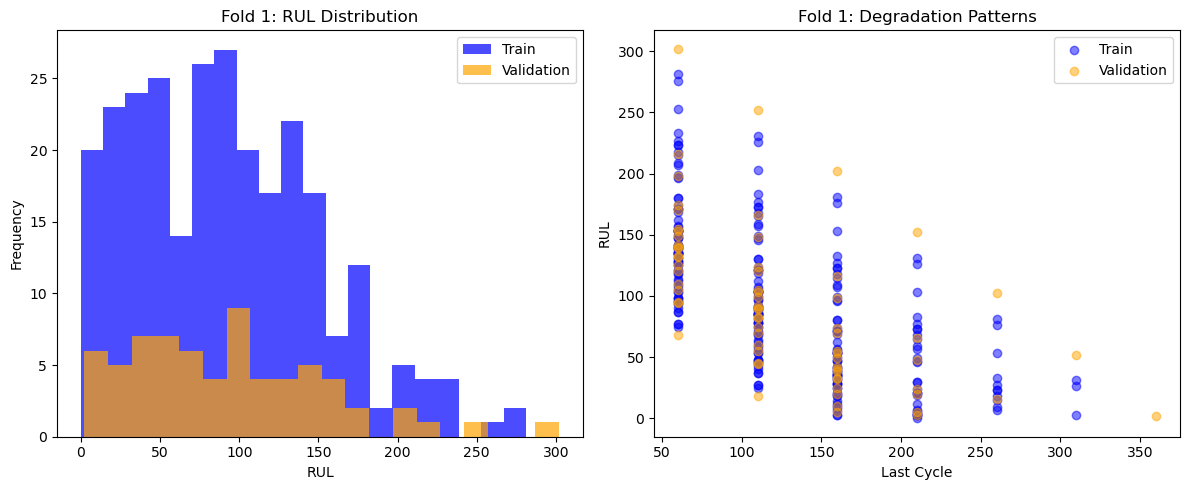

Inspecting Fold 2
  Training RUL Statistics:
count    271.000000
mean      92.151291
std       59.331177
min        2.000000
25%       44.500000
50%       88.000000
75%      132.000000
max      302.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     69.000000
mean      91.014496
std       60.895161
min        0.000000
25%       39.000000
50%       85.000000
75%      130.000000
max      281.000000
Name: RUL, dtype: float64


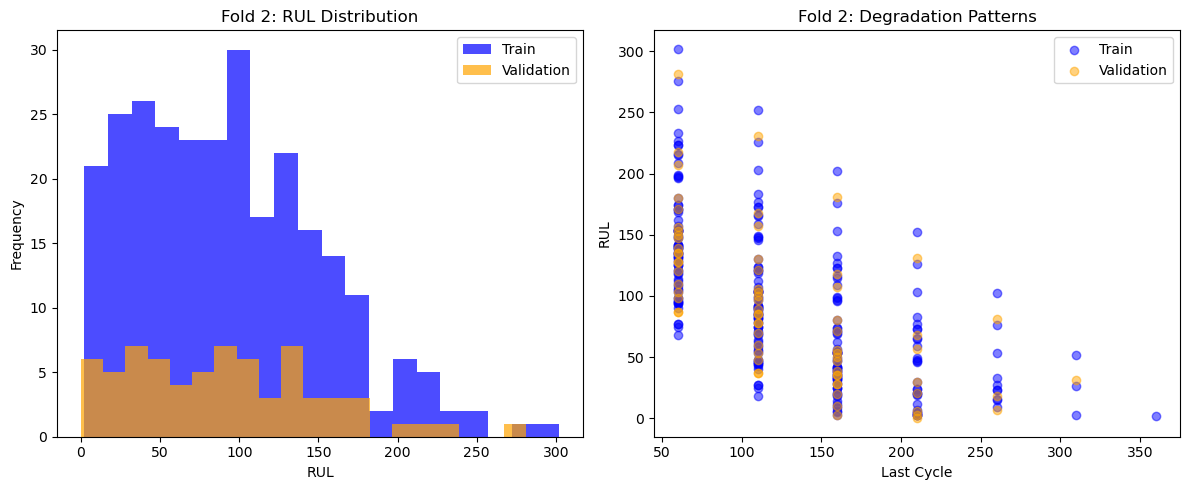

Inspecting Fold 3
  Training RUL Statistics:
count    272.000000
mean      91.897057
std       59.587978
min        0.000000
25%       44.750000
50%       87.000000
75%      131.250000
max      302.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     68.000000
mean      92.014709
std       59.904530
min        3.000000
25%       42.750000
50%       85.500000
75%      130.500000
max      276.000000
Name: RUL, dtype: float64


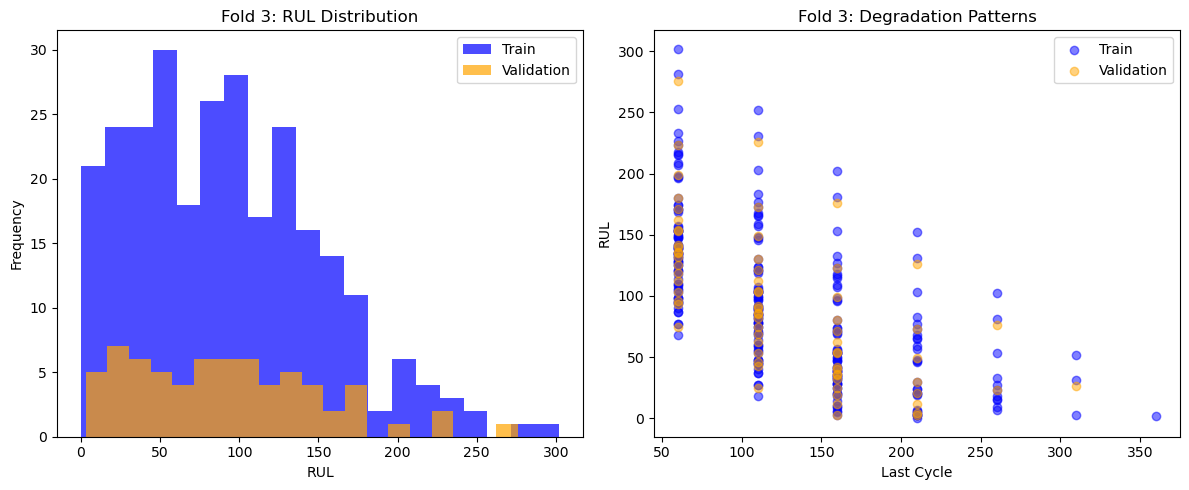

Inspecting Fold 4
  Training RUL Statistics:
count    271.000000
mean      92.387451
std       59.704155
min        0.000000
25%       44.000000
50%       87.000000
75%      131.500000
max      302.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     69.000000
mean      90.086960
std       59.402843
min        3.000000
25%       46.000000
50%       85.000000
75%      131.000000
max      253.000000
Name: RUL, dtype: float64


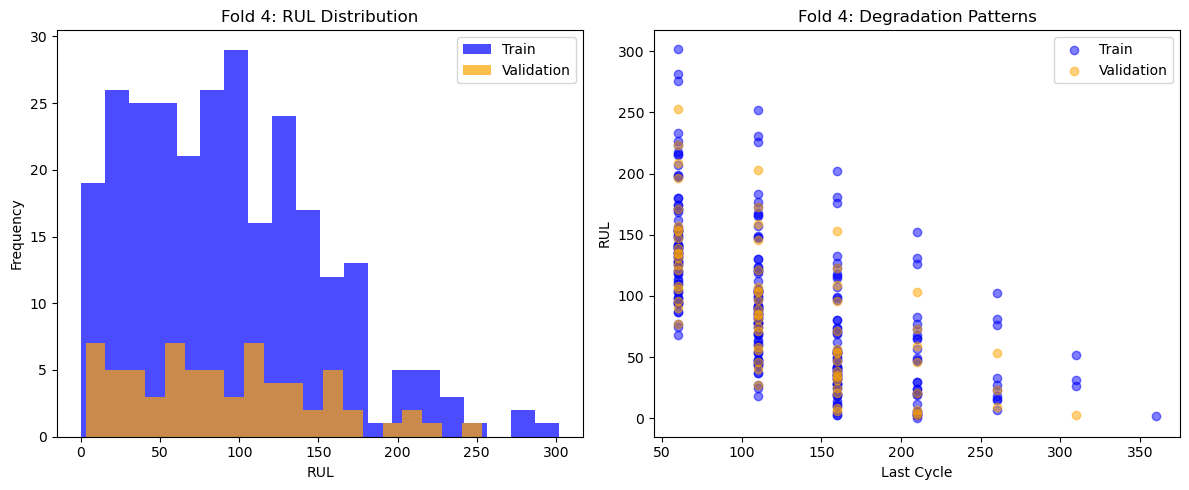

Inspecting Fold 5
  Training RUL Statistics:
count    274.000000
mean      91.408760
std       60.358761
min        0.000000
25%       43.250000
50%       85.500000
75%      131.000000
max      302.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count     66.000000
mean      94.045456
std       56.530846
min        3.000000
25%       47.250000
50%       89.500000
75%      132.000000
max      233.000000
Name: RUL, dtype: float64


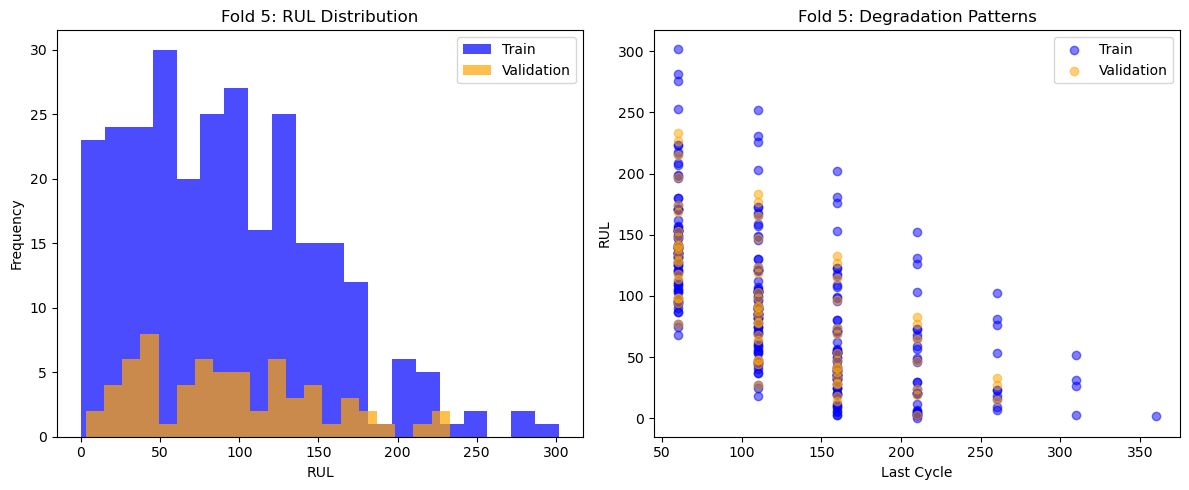

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# K-Fold evaluation and development of model as preparation for a final training

In [9]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v3.models import RNNBaselineModel
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(feature_cols)  # Number of input features

def train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, patience=10):
    """
    Train and validate the model using grouped k-fold cross-validation with early stopping.
    Summarizes metrics (e.g., RMSE, Avg MSE) across all folds.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train for each fold.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics across all folds.
    """
    # Track metrics for all folds
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Loop over each fold
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validation Fold {fold + 1}")
        
        # Initialize model, loss function, and optimizer
        model = RNNBaselineModel(**model_config)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        # Initialize progress bar for this fold
        total_batches = len(train_loader) * epochs
        with tqdm(total=total_batches, desc=f"Fold {fold + 1} Training", unit="batch") as pbar:
            for epoch in range(epochs):
                if early_stop:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
                
                model.train()
                train_loss = 0.0  # Track training loss
                num_train_sequences = len(train_loader.dataset)

                # Training loop
                for inputs, targets, _, _ in train_loader:
                    optimizer.zero_grad()
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    train_loss += loss.item() * inputs.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                
                # Compute training metrics
                avg_train_mse = train_loss / num_train_sequences
                train_rmse = avg_train_mse ** 0.5

                # Validation loop
                model.eval()
                val_loss = 0.0
                num_val_sequences = len(val_loader.dataset)
                with torch.no_grad():
                    for inputs, targets, _, _ in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        
                        # Forward pass
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        # Accumulate validation loss
                        val_loss += loss.item() * inputs.size(0)
                
                # Compute validation metrics
                avg_val_mse = val_loss / num_val_sequences
                val_rmse = avg_val_mse ** 0.5

                # Check for early stopping
                if avg_val_mse < best_val_loss:
                    best_val_loss = avg_val_mse
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    early_stop = True

                # Print epoch metrics
                pbar.set_postfix({
                    "Epoch": f"{epoch + 1}/{epochs}",
                    "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                    "Val Loss:": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
                })
                pbar.update(0)

        # Store fold metrics
        fold_metrics["train_rmse"].append(train_rmse)
        fold_metrics["val_rmse"].append(val_rmse)
        fold_metrics["train_avg_mse"].append(avg_train_mse)
        fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics across all folds
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- k-Fold Cross-Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

# Define model configuration
model_config = {
    "input_dim": input_dim,
    "hidden_dim": 256,
    "num_layers": 4
}

# Train using k-fold loaders
summary = train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, patience=10)

Validation Fold 1


Fold 1 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 21
Validation Fold 2


Fold 2 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

Validation Fold 3


Fold 3 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 261
Validation Fold 4


Fold 4 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 15
Validation Fold 5


Fold 5 Training:   0%|          | 0/1000 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 16

--- k-Fold Cross-Validation Summary ---
mean_train_rmse: 89.4113
mean_val_rmse: 90.7412
mean_train_avg_mse: 8518.5961
mean_val_avg_mse: 8703.4780
